# Supervised (age) regression models

Train `RandomForestRegressor` models on 
  - merged latent space of all chromosomes

In [1]:
import pandas as pd
import numpy as np
import os
import pickle 
import json
import torch
from data.prepareData import prepareDataLoader_fromPkl
from scripts.train_RFregressor import RFregression
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
''' 
Merge latent space of all chromosomes
'''

train_lat = np.empty((504,0))
test_lat = np.empty((144,0))

for CHR in [f"chr{i}" for i in range(1,23)]:
    print(CHR)
    PATH_data = "/data/scratch/skatz/PROJECTS/methylnet/1_healthyVAE/data/GSE87571/train_val_test_sets/"
    
    ## Load Data
    with open(os.path.join(PATH_data, f"{CHR}_train_methyl_array.pkl"), "rb") as f: train_dataset = pickle.load(f) #
    train_tensor = prepareDataLoader_fromPkl(f"{PATH_data}/{CHR}_train_methyl_array.pkl", colName="Age").returnTensor_()
    
    with open(os.path.join(PATH_data, f"{CHR}_test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f) #
    test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)
    
    ## Load model
    PATH_model= f"logs/finalModels/{CHR}"
    with open(f"{PATH_model}/param_grid.json", "r") as f: dict_bestModel = json.load(f)
    latSize = dict_bestModel["latentSize"]
    name = f"latSize_{latSize}"
    model = torch.load(f"{PATH_model}/{name}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))
    
    # Generate latent space
    with torch.no_grad():
        latSpace_train = model.generate_embedding(train_tensor[0]).detach().numpy()
        latSpace_test = model.generate_embedding(test_tensor).detach().numpy()
    
    train_lat = np.concatenate((train_lat, latSpace_train), axis=1)
    test_lat = np.concatenate((test_lat, latSpace_test), axis=1) 
 
print(train_lat.shape)
print(test_lat.shape)  

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22
(504, 1389)
(144, 1389)


RMSE: 8.71524494237508


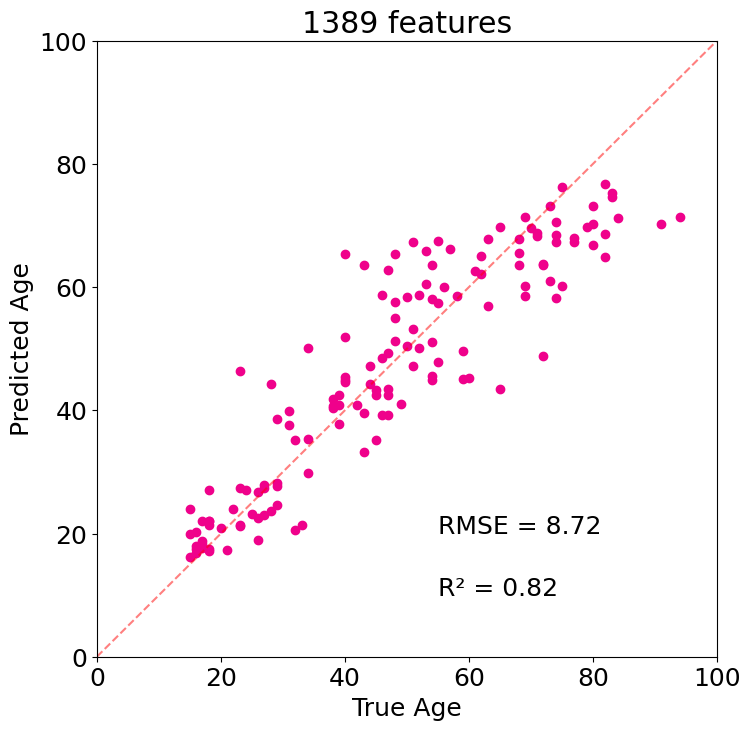

In [5]:
_, fi, r2, rmse = RFregression(X_train=train_lat, 
                             y_train=train_tensor[1].detach().numpy(),
                             X_test=test_lat,
                             y_test=test_dataset["pheno"]["Age"].values,
                             name='test',
                             plot=True, 
                             color=np.random.random(3),
                             title = "",
                             saveModel=False)


# Phenotype: Sex

In [4]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
plt.style.use('default')

Text(0.5, 1.0, 'Sex')

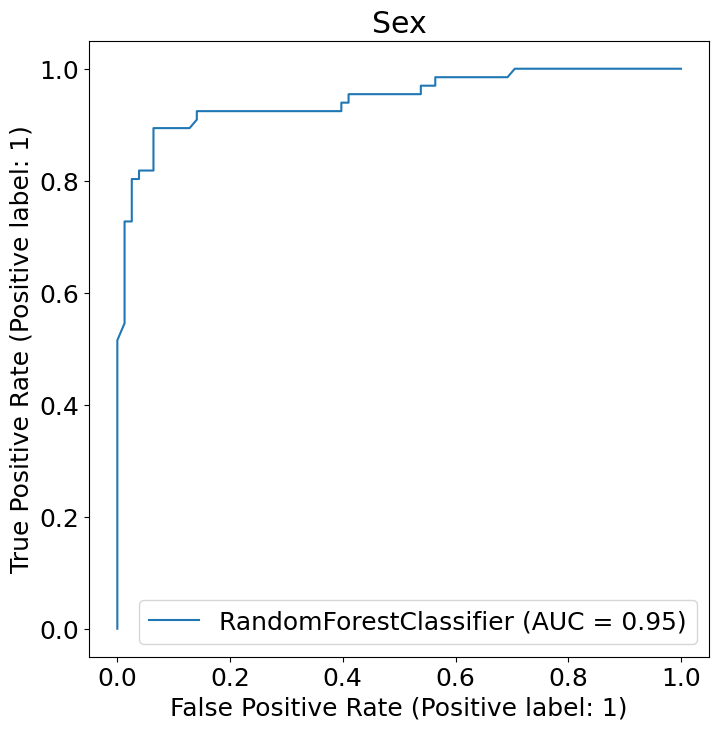

In [6]:
pheno = "Sex"
train_y_sex = train_dataset["pheno"][pheno]
test_y_sex = test_dataset["pheno"][pheno]
## Encode binary; F = 1, M = 0
dic_encode_y = {"M":0, "F":1, "N":0}
train_y_sex_binary = train_y_sex.replace(dic_encode_y)
test_y_sex_binary = test_y_sex.replace(dic_encode_y)

### Train Classifier and predict
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(train_lat, train_y_sex_binary)

### Visualise
plt.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(1, 1, figsize=(8,8))
RocCurveDisplay.from_estimator(rf, test_lat, test_y_sex_binary, ax=ax1)
ax1.set_title(pheno)